# Convolutional Neural Network trained in order to recognize its master (me); LEVEQUE Alexandre.

In [1]:
import warnings
warnings.filterwarnings("ignore")
import os, cv2, random
import numpy as np
import pandas as pd
%pylab inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib import ticker
import seaborn as sns
%matplotlib inline 

from keras.models import Sequential
from keras.layers import Input, Dropout, Flatten, Convolution2D, MaxPooling2D, Dense, Activation
from keras.optimizers import RMSprop
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping
from keras.utils import np_utils

Populating the interactive namespace from numpy and matplotlib


Using TensorFlow backend.


In [2]:
path = ''

In [3]:
### Preparing data

# loading labels for each image from csv
labels = pd.read_csv('./imagesCNN/results.csv')
labels = labels.iloc[:,0:2]
labels.head()

,Filename,isAlexandre
0,Aaron_Patterson_0001.jpg,0
1,Aaron_Peirsol_0001.jpg,0
2,Aaron_Peirsol_0002.jpg,0
3,Aaron_Peirsol_0003.jpg,0
4,Aaron_Peirsol_0004.jpg,0


In [4]:
# Separating non Alexandre labels
nonAlexandre_data = labels[labels['isAlexandre'] == 0]
nonAlexandre_data.head()

,Filename,isAlexandre
0,Aaron_Patterson_0001.jpg,0
1,Aaron_Peirsol_0001.jpg,0
2,Aaron_Peirsol_0002.jpg,0
3,Aaron_Peirsol_0003.jpg,0
4,Aaron_Peirsol_0004.jpg,0


In [5]:
# Splitting non Alexandre data into train and test
test_nonAlexandre_data = nonAlexandre_data.iloc[-3:,:]
train_nonAlexandre_data = nonAlexandre_data.iloc[:-3,:]

In [6]:
# Separating Alexandre labels
Alexandre_data = labels[labels['isAlexandre'] == 1]
Alexandre_data.head()

,Filename,isAlexandre
102,Leveque_Alexandre_0001.jpg,1
103,Leveque_Alexandre_0002.jpg,1
104,Leveque_Alexandre_0003.jpg,1
105,Leveque_Alexandre_0004.jpg,1
106,Leveque_Alexandre_0005.jpg,1


In [7]:
# Splitting Alexandre data into train and test
test_Alexandre_data = Alexandre_data.iloc[-3:,:]
train_Alexandre_data = Alexandre_data.iloc[:-3,:]

In [8]:
train_nonAlexandre_data

,Filename,isAlexandre
0,Aaron_Patterson_0001.jpg,0
1,Aaron_Peirsol_0001.jpg,0
2,Aaron_Peirsol_0002.jpg,0
3,Aaron_Peirsol_0003.jpg,0
4,Aaron_Peirsol_0004.jpg,0
...,...,...
94,Brad_Miller_0001.jpg,0
95,Brandon_Hammond_0001.jpg,0
96,Branko_Crvenkovski_0001.jpg,0
97,Branko_Crvenkovski_0002.jpg,0


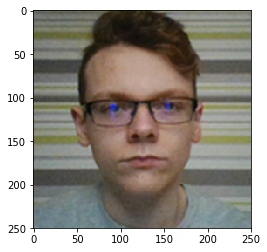

In [9]:
# Displaying one image to check
img=mpimg.imread('./imagesCNN/dataset/Leveque_Alexandre_0001.jpg')
imgplot = plt.imshow(img)
plt.show()

In [10]:
test_indices = test_Alexandre_data.index.tolist() + test_nonAlexandre_data.index.tolist()

In [11]:
# total test data
test_data = labels.iloc[test_indices,:]
test_data.head()

,Filename,isAlexandre
149,Leveque_Alexandre_0048.jpg,1
150,Leveque_Alexandre_0049.jpg,1
151,Leveque_Alexandre_0050.jpg,1
99,Brent_Coles_0001.jpg,0
100,Brian_Pavlich_0001.jpg,0


In [12]:
# total train data
train_data = pd.concat([labels, test_data, test_data]).drop_duplicates(keep=False)
train_data.tail()

,Filename,isAlexandre
144,Leveque_Alexandre_0043.jpg,1
145,Leveque_Alexandre_0044.jpg,1
146,Leveque_Alexandre_0045.jpg,1
147,Leveque_Alexandre_0046.jpg,1
148,Leveque_Alexandre_0047.jpg,1


In [13]:
path = './imagesCNN/dataset/'
# train and test with image name along with paths
train_image_name = [path+each for each in train_data['Filename'].values.tolist()]
test_image_name = [path+each for each in test_data['Filename'].values.tolist()]

In [14]:
# preparing data by processing images using opencv
# not resizing here, takes longer to train
ROWS = 250 #Resizing the size of the pictures
COLS = 250 #Resizing the size of the pictures
CHANNELS = 3 #RGB

def read_image(file_path):
    img = cv2.imread(file_path, cv2.IMREAD_COLOR) #cv2.IMREAD_GRAYSCALE
    return cv2.resize(img, (ROWS, COLS), interpolation=cv2.INTER_CUBIC)


def prep_data(images):
    count = len(images)
    data = np.ndarray((count, CHANNELS, ROWS, COLS), dtype=np.uint8)

    for i, image_file in enumerate(images):
        image = read_image(image_file)
        data[i] = image.T
        if i%5 == 0: print('Processed {} of {}'.format(i, count))
    
    return data

train = prep_data(train_image_name)
test = prep_data(test_image_name)

Processed 0 of 146
Processed 5 of 146
Processed 10 of 146
Processed 15 of 146
Processed 20 of 146
Processed 25 of 146
Processed 30 of 146
Processed 35 of 146
Processed 40 of 146
Processed 45 of 146
Processed 50 of 146
Processed 55 of 146
Processed 60 of 146
Processed 65 of 146
Processed 70 of 146
Processed 75 of 146
Processed 80 of 146
Processed 85 of 146
Processed 90 of 146
Processed 95 of 146
Processed 100 of 146
Processed 105 of 146
Processed 110 of 146
Processed 115 of 146
Processed 120 of 146
Processed 125 of 146
Processed 130 of 146
Processed 135 of 146
Processed 140 of 146
Processed 145 of 146
Processed 0 of 6
Processed 5 of 6


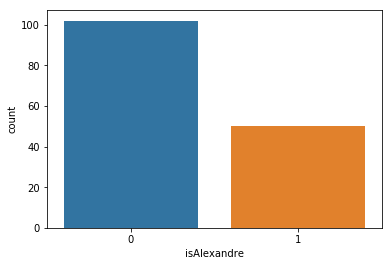

In [15]:
# checking count of Alexandre and nonAlexandre
sns.countplot(labels['isAlexandre'])

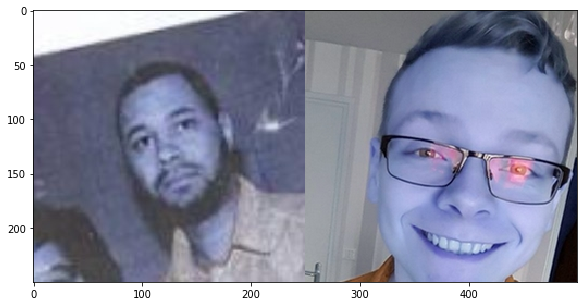

In [16]:
# plotting nonAlexandre and Alexandre side by side
def show_notAlexandre_and_Alexandre():
    Alexandre = read_image(train_image_name[0])
    notAlexandre = read_image(train_image_name[101])
    pair = np.concatenate((Alexandre, notAlexandre), axis=1)
    plt.figure(figsize=(10,5))
    plt.imshow(pair)
    plt.show()
    
show_notAlexandre_and_Alexandre()

In [17]:
train_image_name[0]

'./imagesCNN/dataset/Aaron_Patterson_0001.jpg'

In [18]:
# splitting path of all images into notAlexandre and Alexandre
train_nonAlexandre_image = []
train_Alexandre_image = []
for each in train_image_name:
    if each.split('/')[2] in train_nonAlexandre_data['Filename'].values:
        train_nonAlexandre_image.append(each)
    else:
        train_Alexandre_image.append(each)

# Creating the VGG 16 model

In [19]:
### Creating VGG 16 model for training it on Alexandre and non Alexandre data

optimizer = RMSprop(lr=1e-4)
objective = 'binary_crossentropy'


def alexandreOrNot():
    
    model = Sequential()

    model.add(Convolution2D(32, 3, 3, border_mode='same', input_shape=(3, ROWS, COLS), activation='relu'))
    model.add(Convolution2D(32, 3, 3, border_mode='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), dim_ordering="th"))

    model.add(Convolution2D(64, 3, 3, border_mode='same', activation='relu'))
    model.add(Convolution2D(64, 3, 3, border_mode='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), dim_ordering="th"))
    
    model.add(Convolution2D(128, 3, 3, border_mode='same', activation='relu'))
    model.add(Convolution2D(128, 3, 3, border_mode='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), dim_ordering="th"))
    
    model.add(Convolution2D(256, 3, 3, border_mode='same', activation='relu'))
    model.add(Convolution2D(256, 3, 3, border_mode='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), dim_ordering="th"))

    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))

    model.add(Dense(1))
    model.add(Activation('sigmoid'))

    model.compile(loss=objective, optimizer=optimizer, metrics=['accuracy'])
    return model


model = alexandreOrNot()

W1222 14:50:28.279424 140100758054720 deprecation_wrapper.py:119] From /home/alexandre/anaconda3/envs/IA-DeepLearning/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W1222 14:50:28.287538 140100758054720 deprecation_wrapper.py:119] From /home/alexandre/anaconda3/envs/IA-DeepLearning/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W1222 14:50:28.293825 140100758054720 deprecation_wrapper.py:119] From /home/alexandre/anaconda3/envs/IA-DeepLearning/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W1222 14:50:28.413659 140100758054720 deprecation_wrapper.py:119] From /home/alexandre/anaconda3/envs/IA-DeepLearning/lib/python3.7/site-packages/keras/backend/tensorflow_backe

In [20]:
labs = train_data.iloc[:,1].values.tolist()

nb_epoch = 10
batch_size = 8

## Callback for loss logging per epoch
class LossHistory(Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
        self.val_losses = []
        
    def on_epoch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))

early_stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=1, mode='auto')        
        
history = LossHistory()

In [21]:
labs

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1]

# Training of the model

In [22]:
model.fit(train, labs, batch_size=batch_size, epochs=nb_epoch,
              validation_split=0.25, verbose=1, shuffle=True, callbacks=[history, early_stopping])

Train on 109 samples, validate on 37 samples
Epoch 1/10
109/109 [==============================] - 47s 427ms/step - loss: 1.2175 - acc: 0.8073 - val_loss: 2.3055 - val_acc: 0.0000e+00
Epoch 2/10
109/109 [==============================] - 37s 338ms/step - loss: 0.5448 - acc: 0.8073 - val_loss: 3.0013 - val_acc: 0.0000e+00
Epoch 3/10
109/109 [==============================] - 35s 318ms/step - loss: 0.3656 - acc: 0.8807 - val_loss: 3.9844 - val_acc: 0.0000e+00
Epoch 4/10
109/109 [==============================] - 34s 316ms/step - loss: 0.3514 - acc: 0.8991 - val_loss: 2.7646 - val_acc: 0.0000e+00
Epoch 00004: early stopping


In [23]:
predictions = model.predict(test, verbose=1)

6/6 [==============================] - 2s 285ms/step


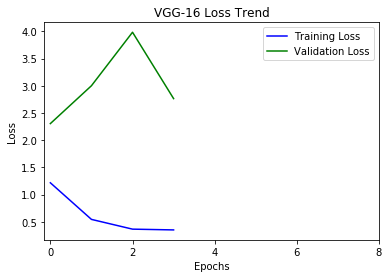

In [24]:
loss = history.losses
val_loss = history.val_losses

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('VGG-16 Loss Trend')
plt.plot(loss, 'blue', label='Training Loss')
plt.plot(val_loss, 'green', label='Validation Loss')
plt.xticks(range(0,nb_epoch)[0::2])
plt.legend()
plt.show()

# Test of the model with the test set

I think it is Alexandre LEVEQUE ( 16.21% )


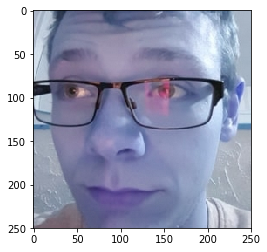

I think it is Alexandre LEVEQUE ( 15.79% )


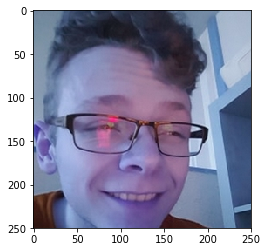

I think it is Alexandre LEVEQUE ( 14.08% )


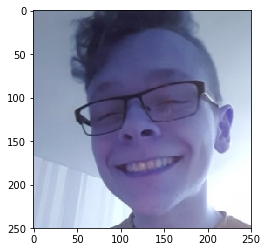

I think it is not Alexandre LEVEQUE ( 96.82% )


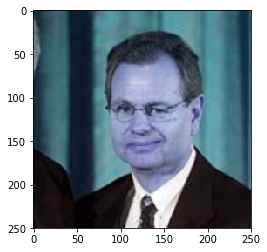

I think it is not Alexandre LEVEQUE ( 95.07% )


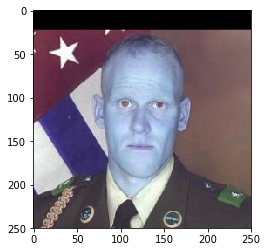

I think it is not Alexandre LEVEQUE ( 98.26% )


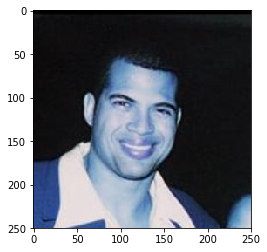

In [42]:
#When the model think that an image contains Alexandre with more than 10%,
#we conclude this picture contains Alexandre.
THRESHOLD=0.10

#It is because the dataset isn't large enough at all to have a solid 50%

for i in range(0,6):
    if predictions[i, 0] >= THRESHOLD: 
        print('I think it is Alexandre LEVEQUE ( {:.2%} )'.format(predictions[i][0]))
    else: 
        print('I think it is not Alexandre LEVEQUE ( {:.2%} )'.format(1-predictions[i][0]))
        
    plt.imshow(test[i].T)
    plt.show()

# Test of the model with your own pictures

In [26]:
def read_single_image(file_path):
    img = cv2.imread(file_path, cv2.IMREAD_COLOR) #cv2.IMREAD_GRAYSCALE
    return cv2.resize(img, (ROWS, COLS), interpolation=cv2.INTER_CUBIC)


def prep_single_data(images):
    data = np.ndarray((1, CHANNELS, ROWS, COLS), dtype=np.uint8)
    image = read_single_image(images)
    data[0] = image.T  
    return data

test2 = prep_single_data('./imagesCNN/testYourselfPictures/Leveque_Alexandre_0051.jpg')
percentage=model.predict(test2,verbose=1)
percentage[0]

1/1 [==============================] - 0s 308ms/step


array([0.15583153], dtype=float32)

I think it is Alexandre LEVEQUE ( 15.58% )


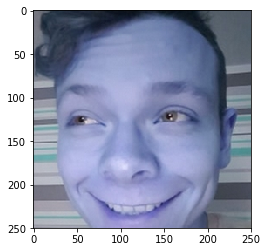

In [27]:
percentage=percentage[0]
if percentage[0] >= THRESHOLD: 
    print('I think it is Alexandre LEVEQUE ( {:.2%} )'.format(percentage[0]))
else: 
    print('I think it is not Alexandre LEVEQUE ( {:.2%} )'.format(1-percentage[0]))
        
plt.imshow(test2[0].T)
plt.show()

In [28]:
test2 = prep_single_data('./imagesCNN/testYourselfPictures/Leveque_Alexandre_0052.jpg')
percentage=model.predict(test2,verbose=1)
percentage[0]

1/1 [==============================] - 0s 310ms/step


array([0.16557331], dtype=float32)

I think it is Alexandre LEVEQUE ( 16.56% )


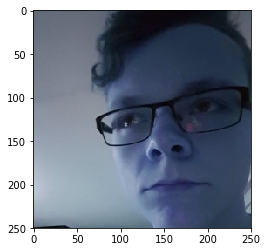

In [29]:
percentage=percentage[0]
if percentage[0] >= THRESHOLD: 
    print('I think it is Alexandre LEVEQUE ( {:.2%} )'.format(percentage[0]))
else: 
    print('I think it is not Alexandre LEVEQUE ( {:.2%} )'.format(1-percentage[0]))
        
plt.imshow(test2[0].T)
plt.show()

1/1 [==============================] - 0s 285ms/step
I think it is not Alexandre LEVEQUE ( 97.58% )


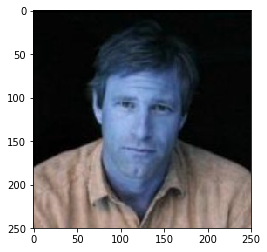

In [30]:
test2 = prep_single_data('./imagesCNN/testYourselfPictures/Aaron_Eckhart_0001.jpg')
percentage=model.predict(test2,verbose=1)
percentage[0]

percentage=percentage[0]
if percentage[0] >= THRESHOLD: 
    print('I think it is Alexandre LEVEQUE ( {:.2%} )'.format(percentage[0]))
else: 
    print('I think it is not Alexandre LEVEQUE ( {:.2%} )'.format(1-percentage[0]))
        
plt.imshow(test2[0].T)
plt.show()

1/1 [==============================] - 0s 275ms/step
I think it is not Alexandre LEVEQUE ( 94.79% )


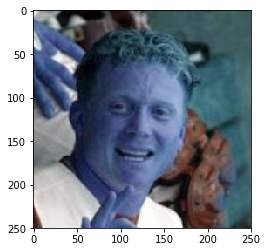

In [31]:
test2 = prep_single_data('./imagesCNN/testYourselfPictures/Aaron_Guiel_0001.jpg')
percentage=model.predict(test2,verbose=1)
percentage[0]

percentage=percentage[0]
if percentage[0] >= THRESHOLD: 
    print('I think it is Alexandre LEVEQUE ( {:.2%} )'.format(percentage[0]))
else: 
    print('I think it is not Alexandre LEVEQUE ( {:.2%} )'.format(1-percentage[0]))
        
plt.imshow(test2[0].T)
plt.show()

# Can be incorrect

1/1 [==============================] - 0s 342ms/step
I think it is Alexandre LEVEQUE ( 11.20% )


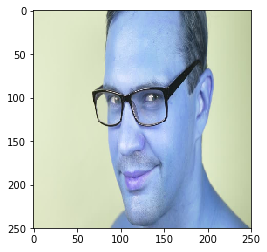

In [38]:
#Any man with glasses has a high probability to be detected as me... 
#Not enough image of me without glasses for the training set probably.

test2 = prep_single_data('./imagesCNN/testYourselfPictures/Leveque_Alexandre_lookalike.jpg')
percentage=model.predict(test2,verbose=1)
percentage[0]

percentage=percentage[0]
if percentage[0] >= THRESHOLD: 
    print('I think it is Alexandre LEVEQUE ( {:.2%} )'.format(percentage[0]))
else: 
    print('I think it is not Alexandre LEVEQUE ( {:.2%} )'.format(1-percentage[0]))
        
plt.imshow(test2[0].T)
plt.show()

1/1 [==============================] - 0s 331ms/step
I think it is not Alexandre LEVEQUE ( 93.64% )


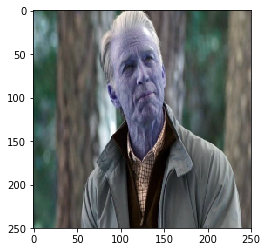

In [39]:
test2 = prep_single_data('./imagesCNN/testYourselfPictures/Captain_America_oldman.jpg')
percentage=model.predict(test2,verbose=1)
percentage[0]

percentage=percentage[0]
if percentage[0] >= THRESHOLD: 
    print('I think it is Alexandre LEVEQUE ( {:.2%} )'.format(percentage[0]))
else: 
    print('I think it is not Alexandre LEVEQUE ( {:.2%} )'.format(1-percentage[0]))
        
plt.imshow(test2[0].T)
plt.show()

1/1 [==============================] - 0s 336ms/step
I think it is not Alexandre LEVEQUE ( 95.66% )


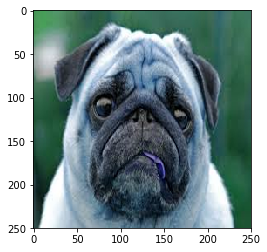

In [40]:
test2 = prep_single_data('./imagesCNN/testYourselfPictures/cuteDog.jpg')
percentage=model.predict(test2,verbose=1)
percentage[0]

percentage=percentage[0]
if percentage[0] >= THRESHOLD: 
    print('I think it is Alexandre LEVEQUE ( {:.2%} )'.format(percentage[0]))
else: 
    print('I think it is not Alexandre LEVEQUE ( {:.2%} )'.format(1-percentage[0]))
        
plt.imshow(test2[0].T)
plt.show()

1/1 [==============================] - 0s 326ms/step
I think it is not Alexandre LEVEQUE ( 97.28% )


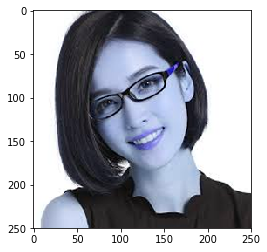

In [41]:
test2 = prep_single_data('./imagesCNN/testYourselfPictures/Random_FemaleWithGlasses.jpg')
percentage=model.predict(test2,verbose=1)
percentage[0]

percentage=percentage[0]
if percentage[0] >= THRESHOLD: 
    print('I think it is Alexandre LEVEQUE ( {:.2%} )'.format(percentage[0]))
else: 
    print('I think it is not Alexandre LEVEQUE ( {:.2%} )'.format(1-percentage[0]))
        
plt.imshow(test2[0].T)
plt.show()